# Background

* Cluster cell lines based on in vitro sensitivity to pyrimethamine (IC50 + AUC; test 2 and 3 clusters)
* Use the newly defined IC50 cutoffs to label cell lines as sensitive, partially sensitive, or resistant
* Cluster cell lines based on gene expression and look for overlap with pyrimethamine sensitivity (essentially predict cell line sensitivity using gene expression data)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import umap
from sklearn import metrics
%matplotlib inline

# Load Data

In [2]:
# Load data from CSV files into data frames
gdsc_df = pd.read_csv('GDSC_PYR.csv') # GDSC pyrimethamine sensitivity data
ccle_df = pd.read_csv('CCLE_expression.csv') # CCLE gene expression data
info_df = pd.read_csv('sample_info.csv') # CCLE cell line key

In [3]:
# Preview first 5 lines of gdsc_df
gdsc_df.head()

Cell line TCGA classification            Tissue          Tissue sub-type  \
0   LS-411N              COREAD  digestive_system          large_intestine   
1       ES1        UNCLASSIFIED              bone           ewings_sarcoma   
2       ES8        UNCLASSIFIED              bone           ewings_sarcoma   
3    ALL-PO                 ALL             blood   lymphoblastic_leukemia   
4   WIL2-NS        UNCLASSIFIED             blood  lymphoid_neoplasm_other   

       IC50       AUC  
0  0.722230  0.420598  
1  1.027104  0.470035  
2  1.069459  0.474589  
3  1.134090  0.484931  
4  1.196133  0.492336

# Clean and Process Data

In [4]:
# Drop TCGA classification, Tissue, and Tissue sub-type from gdsc_df
columns_to_drop = ['TCGA classification', 'Tissue', 'Tissue sub-type']
gdsc_df.drop(columns_to_drop, axis=1, inplace=True)

# Remove dashes and spaces from Cell line entries in gdsc_df
gdsc_df['cell_line'] = gdsc_df['Cell line'].str.replace('-', '').str.upper()
gdsc_df.drop('Cell line', axis=1, inplace=True)

# Standardize column naming
gdsc_df.columns = gdsc_df.columns.str.replace(' ', '').str.lower()

# Set ic50 values above max screening concentration to max screening concentration
# 20 uM was the max screening concentration
IC50_list = []

for IC50 in gdsc_df['ic50']:
    if IC50 > 20:
        IC50_list.append(20)
    else:
        IC50_list.append(IC50)
    
gdsc_df['adjusted_ic50'] = IC50_list

# Check resulting data frame
gdsc_df.head()

ic50       auc cell_line  adjusted_ic50
0  0.722230  0.420598    LS411N       0.722230
1  1.027104  0.470035       ES1       1.027104
2  1.069459  0.474589       ES8       1.069459
3  1.134090  0.484931     ALLPO       1.134090
4  1.196133  0.492336    WIL2NS       1.196133

In [5]:
# Preview first 5 lines of info_df
info_df.head()

DepMap_ID stripped_cell_line_name  \
0  ACH-000001               NIHOVCAR3   
1  ACH-000002                    HL60   
2  ACH-000003                   CACO2   
3  ACH-000004                     HEL   
4  ACH-000005                 HEL9217   

                                    CCLE_Name          alias  COSMIC_ID  \
0                             NIHOVCAR3_OVARY         OVCAR3   905933.0   
1     HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE            NaN   905938.0   
2                       CACO2_LARGE_INTESTINE  CACO2, CaCo-2        NaN   
3      HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE            NaN   907053.0   
4  HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE            NaN        NaN   

      lineage            lineage_subtype lineage_sub_subtype  \
0       ovary       ovary_adenocarcinoma   high_grade_serous   
1       blood                        AML                  M3   
2  colorectal  colorectal_adenocarcinoma                 NaN   
3       blood                        AML                  M6   
4       blood                        AML                  M6   

  lineage_molecular_subtype     sex  ...     culture_medium  cas9_activity  \
0                       NaN  Female  ...                NaN            NaN   
1                       NaN  Female  ...                NaN            NaN   
2                       NaN    Male  ...                NaN            NaN   
3                       NaN    Male  ...  RPMI-1640: 10%FBS           47.6   
4                       NaN    Male  ...      RPMI; 10% FBS           13.4   

        RRID              sample_collection_site primary_or_metastasis  \
0  CVCL_0465                             ascites            Metastasis   
1  CVCL_0002  haematopoietic_and_lymphoid_tissue               Primary   
2  CVCL_0025                               Colon                   NaN   
3  CVCL_0001  haematopoietic_and_lymphoid_tissue                   NaN   
4  CVCL_2481                         bone_marrow                   NaN   

                   disease                                    disease_subtype  \
0           Ovarian Cancer                  Adenocarcinoma, high grade serous   
1                 Leukemia  Acute Myelogenous Leukemia (AML), M3 (Promyelo...   
2  Colon/Colorectal Cancer                                     Adenocarcinoma   
3                 Leukemia  Acute Myelogenous Leukemia (AML), M6 (Erythrol...   
4                 Leukemia  Acute Myelogenous Leukemia (AML), M6 (Erythrol...   

    age Sanger_model_ID additional_info  
0  60.0       SIDM00105             NaN  
1  35.0       SIDM00829             NaN  
2   NaN       SIDM00891             NaN  
3  30.0       SIDM00594             NaN  
4  30.0       SIDM00593             NaN  

[5 rows x 24 columns]

In [6]:
# Drop all columns except DepMap_ID, stripped_cell_line_name, and lineage
columns_to_drop = ['CCLE_Name', 'alias','COSMIC_ID', 'lineage_subtype', 'lineage_sub_subtype',
       'lineage_molecular_subtype', 'sex', 'source', 'Achilles_n_replicates',
       'cell_line_NNMD', 'culture_type', 'culture_medium', 'cas9_activity',
       'RRID', 'sample_collection_site', 'primary_or_metastasis', 'disease',
       'disease_subtype', 'age', 'Sanger_model_ID', 'additional_info']

info_df.drop(columns_to_drop, axis=1, inplace=True)

# Standardize column naming
info_df.columns = info_df.columns.str.replace(' ', '').str.lower()

# Check resulting data frame
info_df.head()

depmap_id stripped_cell_line_name     lineage
0  ACH-000001               NIHOVCAR3       ovary
1  ACH-000002                    HL60       blood
2  ACH-000003                   CACO2  colorectal
3  ACH-000004                     HEL       blood
4  ACH-000005                 HEL9217       blood

In [7]:
# Preview first 5 lines of ccle_df
ccle_df.head()

Unnamed: 0  TSPAN6 (7105)  TNMD (64102)  DPM1 (8813)  SCYL3 (57147)  \
0  ACH-001097       0.000000           0.0     4.667324       1.761285   
1  ACH-001636       0.000000           0.0     6.198887       2.032101   
2  ACH-001804       4.934988           0.0     6.635464       1.929791   
3  ACH-000534       0.839960           0.0     5.376082       2.687061   
4  ACH-000742       3.722466           0.0     6.029674       2.192194   

   C1orf112 (55732)  FGR (2268)  CFH (3075)  FUCA2 (2519)  GCLC (2729)  ...  \
0          3.554589    4.358959    0.641546      2.201634     1.941106  ...   
1          3.755956    2.601697    0.000000      0.000000     3.415488  ...   
2          2.503349    0.000000    4.883621      6.772546     3.889474  ...   
3          4.440288    4.938286    0.536053      3.584963     2.935460  ...   
4          2.533563    0.150560    5.933809      6.973382     5.192194  ...   

   SCYGR3 (112441429)  SCYGR7 (112441438)  OR8S1 (341568)  SCYGR6 (112441431)  \
0                 0.0                 0.0             0.0                 0.0   
1                 0.0                 0.0             0.0                 0.0   
2                 0.0                 0.0             0.0                 0.0   
3                 0.0                 0.0             0.0                 0.0   
4                 0.0                 0.0             0.0                 0.0   

   OR4F29 (729759)  EEF1AKMT4 (110599564)  TBCE (6905)  OOSP4A (112577462)  \
0              0.0               2.980025     5.132988                 0.0   
1              0.0               4.322649     4.100978                 0.0   
2              0.0               2.283922     4.288359                 0.0   
3              0.0               1.333424     4.841470                 0.0   
4              0.0               1.526069     4.494416                 0.0   

   ARHGAP11B (89839)  OOSP3 (112577461)  
0           0.443607           0.000000  
1           2.589763           0.298658  
2           0.475085           0.000000  
3           3.904966           0.000000  
4           0.941106           0.000000  

[5 rows x 19145 columns]

In [8]:
# Merge ccle_df with info_df on depmap_id
ccle_info_merge = pd.merge(left=ccle_df, right=info_df, left_on='Unnamed: 0', right_on='depmap_id', how='inner')

# Merge ccle_info_merge with gdsc_df on cell_line
final_df = pd.merge(left=ccle_info_merge, right=gdsc_df, left_on='stripped_cell_line_name', right_on='cell_line', how='inner')

# Check resulting data frame
final_df

Unnamed: 0  TSPAN6 (7105)  TNMD (64102)  DPM1 (8813)  SCYL3 (57147)  \
0    ACH-000534       0.839960      0.000000     5.376082       2.687061   
1    ACH-000981       0.659925      0.000000     5.790772       3.282440   
2    ACH-001400       2.737687      0.000000     3.758090       0.823749   
3    ACH-001702       4.917432      0.000000     6.639956       1.622930   
4    ACH-000772       0.464668      0.000000     6.776367       2.336283   
..          ...            ...           ...          ...            ...   
226  ACH-000394       3.112700      0.056584     5.619413       3.207893   
227  ACH-000795       0.815575      0.000000     6.015248       3.073820   
228  ACH-000514       4.886550      0.000000     5.739038       3.005400   
229  ACH-000864       2.735522      0.000000     5.581050       2.748461   
230  ACH-000305       4.152183      0.000000     6.024364       2.361768   

     C1orf112 (55732)  FGR (2268)  CFH (3075)  FUCA2 (2519)  GCLC (2729)  ...  \
0            4.440288    4.938286    0.536053      3.584963     2.935460  ...   
1            4.945795    6.610434    5.170726      1.257011     4.932628  ...   
2            1.000000    0.516015    3.447579      3.250962     2.341986  ...   
3            3.600508    0.000000    0.111031      6.551824     3.587365  ...   
4            3.456806    0.163499    3.561937      2.459432     4.257765  ...   
..                ...         ...         ...           ...          ...  ...   
226          4.827819    0.150560    3.526069      4.401903     4.695437  ...   
227          5.103078    3.032101    2.799087      0.622930     4.489928  ...   
228          4.626439    0.641546    2.114367      4.303050     4.990047  ...   
229          3.570463    0.042644    0.097611      4.812498     4.745775  ...   
230          1.659925    0.028569    5.154616      6.506367     5.834408  ...   

     OOSP4A (112577462)  ARHGAP11B (89839)  OOSP3 (112577461)   depmap_id  \
0                   0.0           3.904966                0.0  ACH-000534   
1                   0.0           0.555816                0.0  ACH-000981   
2                   0.0           0.687061                0.0  ACH-001400   
3                   0.0           0.895303                0.0  ACH-001702   
4                   0.0           1.835924                0.0  ACH-000772   
..                  ...                ...                ...         ...   
226                 0.0           2.364572                0.0  ACH-000394   
227                 0.0           3.747387                0.0  ACH-000795   
228                 0.0           2.904966                0.0  ACH-000514   
229                 0.0           1.713696                0.0  ACH-000864   
230                 0.0           1.350497                0.0  ACH-000305   

     stripped_cell_line_name      lineage        ic50       auc  cell_line  \
0                   WSUDLCL2   lymphocyte  118.254671  0.984830   WSUDLCL2   
1                      DND41          NaN    6.691083  0.769990      DND41   
2                      SW954       cervix   78.991247  0.964064      SW954   
3                     VAESBJ          NaN   12.583186  0.825335     VAESBJ   
4                     TE441T  soft_tissue   48.295147  0.942900     TE441T   
..                       ...          ...         ...       ...        ...   
226                 NCIH2081         lung  254.331353  0.983144   NCIH2081   
227                   MOLT13          NaN   30.074103  0.921472     MOLT13   
228                 NCIH1092         lung  214.007094  0.972662   NCIH1092   
229                  COLO684          NaN    6.336907  0.730798    COLO684   
230                   ECGI10    esophagus  116.228998  0.970420     ECGI10   

     adjusted_ic50  
0        20.000000  
1         6.691083  
2        20.000000  
3        12.583186  
4        20.000000  
..             ...  
226      20.000000  
227      20.000000  
228      20.000000  
229       6.336907  
230      20.000000  

[231

In [9]:
# Clean up final_df by removing duplicate columns and
# standardizing column names
columns_to_drop = ['Unnamed: 0', 'depmap_id', 'stripped_cell_line_name']
final_df.drop(columns_to_drop, axis=1, inplace=True)

final_df.columns = final_df.columns.str.replace(' ', '').str.lower()
final_df.columns = final_df.columns.str.replace(' ?\([^)]+\)', '')

# Check resulting data frame
final_df

tspan6      tnmd      dpm1     scyl3  c1orf112       fgr       cfh  \
0    0.839960  0.000000  5.376082  2.687061  4.440288  4.938286  0.536053   
1    0.659925  0.000000  5.790772  3.282440  4.945795  6.610434  5.170726   
2    2.737687  0.000000  3.758090  0.823749  1.000000  0.516015  3.447579   
3    4.917432  0.000000  6.639956  1.622930  3.600508  0.000000  0.111031   
4    0.464668  0.000000  6.776367  2.336283  3.456806  0.163499  3.561937   
..        ...       ...       ...       ...       ...       ...       ...   
226  3.112700  0.056584  5.619413  3.207893  4.827819  0.150560  3.526069   
227  0.815575  0.000000  6.015248  3.073820  5.103078  3.032101  2.799087   
228  4.886550  0.000000  5.739038  3.005400  4.626439  0.641546  2.114367   
229  2.735522  0.000000  5.581050  2.748461  3.570463  0.042644  0.097611   
230  4.152183  0.000000  6.024364  2.361768  1.659925  0.028569  5.154616   

        fuca2      gclc      nfya  ...  eef1akmt4      tbce  oosp4a  \
0    3.584963  2.935460  3.157044  ...   1.333424  4.841470     0.0   
1    1.257011  4.932628  5.783719  ...   2.893362  5.384395     0.0   
2    3.250962  2.341986  1.531069  ...   0.659925  4.372256     0.0   
3    6.551824  3.587365  4.203201  ...   2.639232  5.270155     0.0   
4    2.459432  4.257765  4.747924  ...   1.422233  5.234578     0.0   
..        ...       ...       ...  ...        ...       ...     ...   
226  4.401903  4.695437  4.957915  ...   4.063503  5.163499     0.0   
227  0.622930  4.489928  5.514438  ...   3.014355  4.677508     0.0   
228  4.303050  4.990047  5.031219  ...   3.238787  5.713421     0.0   
229  4.812498  4.745775  4.888987  ...   2.028569  5.799605     0.0   
230  6.506367  5.834408  4.206331  ...   4.432959  4.421560     0.0   

     arhgap11b  oosp3      lineage        ic50       auc  cell_line  \
0     3.904966    0.0   lymphocyte  118.254671  0.984830   WSUDLCL2   
1     0.555816    0.0          NaN    6.691083  0.769990      DND41   
2     0.687061    0.0       cervix   78.991247  0.964064      SW954   
3     0.895303    0.0          NaN   12.583186  0.825335     VAESBJ   
4     1.835924    0.0  soft_tissue   48.295147  0.942900     TE441T   
..         ...    ...          ...         ...       ...        ...   
226   2.364572    0.0         lung  254.331353  0.983144   NCIH2081   
227   3.747387    0.0          NaN   30.074103  0.921472     MOLT13   
228   2.904966    0.0         lung  214.007094  0.972662   NCIH1092   
229   1.713696    0.0          NaN    6.336907  0.730798    COLO684   
230   1.350497    0.0    esophagus  116.228998  0.970420     ECGI10   

     adjusted_ic50  
0        20.000000  
1         6.691083  
2        20.000000  
3        12.583186  
4        20.000000  
..             ...  
226      20.000000  
227      20.000000  
228      20.000000  
229       6.336907  
230      20.000000  

[231 rows x 19149 columns]

In [10]:
# Create data frame for X (variables)
columns_to_drop = ['lineage', 'ic50', 'auc', 'cell_line']
X_sens = final_df[['adjusted_ic50', 'auc']]
X_exp = final_df.drop(columns_to_drop, axis=1)

In [11]:
# Use MinMaxScaler to transform X_sens and X_exp
# and reassign to respective data frames
scaler = MinMaxScaler()
sens_mm = scaler.fit_transform(X_sens)
exp_mm = scaler.fit_transform(X_exp)

X_sens_mm = pd.DataFrame(sens_mm, index=X_sens.index, columns=X_sens.columns)
X_exp_mm = pd.DataFrame(exp_mm, index=X_exp.index, columns=X_exp.columns)

In [12]:
# Check resulting data frame
X_sens_mm

adjusted_ic50       auc
0         1.000000  0.992690
1         0.309624  0.614708
2         1.000000  0.956155
3         0.615266  0.712080
4         1.000000  0.918920
..             ...       ...
226       1.000000  0.989724
227       1.000000  0.881220
228       1.000000  0.971282
229       0.291251  0.545755
230       1.000000  0.967337

[231 rows x 2 columns]

In [13]:
# Check resulting data frame
X_exp_mm

tspan6      tnmd      dpm1     scyl3  c1orf112       fgr       cfh  \
0    0.123448  0.000000  0.303694  0.553686  0.691039  0.615552  0.062154   
1    0.096989  0.000000  0.381531  0.730604  0.792579  0.823983  0.599529   
2    0.402357  0.000000  0.000000  0.000000  0.000000  0.064321  0.399736   
3    0.722713  0.000000  0.540921  0.237478  0.522356  0.000000  0.012874   
4    0.068292  0.000000  0.566525  0.449452  0.493491  0.020380  0.412995   
..        ...       ...       ...       ...       ...       ...       ...   
226  0.457472  0.032685  0.349367  0.708452  0.768882  0.018767  0.408836   
227  0.119865  0.000000  0.423664  0.668612  0.824172  0.377948  0.324545   
228  0.718174  0.000000  0.371820  0.648281  0.728431  0.079968  0.245154   
229  0.402038  0.000000  0.342166  0.571931  0.516321  0.005316  0.011318   
230  0.610244  0.000000  0.425376  0.457025  0.132557  0.003561  0.597661   

        fuca2      gclc      nfya  ...  scygr7     or8s1  scygr6    or4f29  \
0    0.467728  0.167532  0.337615  ...     0.0  0.000000     0.0  0.000000   
1    0.164002  0.460897  0.883013  ...     0.0  0.000000     0.0  0.000000   
2    0.424151  0.080356  0.000000  ...     0.0  0.000000     0.0  0.000000   
3    0.854813  0.263291  0.554837  ...     0.0  0.000000     0.0  0.020626   
4    0.320881  0.361766  0.667943  ...     0.0  0.000000     0.0  0.253340   
..        ...       ...       ...  ...     ...       ...     ...       ...   
226  0.574314  0.426056  0.711545  ...     0.0  0.064155     0.0  0.216323   
227  0.081273  0.395868  0.827100  ...     0.0  0.000000     0.0  0.061271   
228  0.561417  0.469331  0.726765  ...     0.0  0.000000     0.0  0.041048   
229  0.627884  0.433450  0.697233  ...     0.0  0.021803     0.0  0.000000   
230  0.848883  0.593359  0.555487  ...     0.0  0.209875     0.0  0.020626   

     eef1akmt4      tbce  oosp4a  arhgap11b  oosp3  adjusted_ic50  
0     0.148446  0.518041     0.0   0.955637    0.0       1.000000  
1     0.492272  0.673486     0.0   0.048048    0.0       0.309624  
2     0.000000  0.383700     0.0   0.083614    0.0       1.000000  
3     0.436259  0.640778     0.0   0.140046    0.0       0.615266  
4     0.168020  0.630592     0.0   0.394946    0.0       1.000000  
..         ...       ...     ...        ...    ...            ...  
226   0.750183  0.610241     0.0   0.538205    0.0       1.000000  
227   0.518940  0.471097     0.0   0.912935    0.0       1.000000  
228   0.568407  0.767689     0.0   0.684646    0.0       1.000000  
229   0.301663  0.792365     0.0   0.361823    0.0       0.291251  
230   0.831615  0.397816     0.0   0.263399    0.0       1.000000  

[231 rows x 19145 columns]

# Cluster Cell Lines Based on IC50 and AUC
Cluster based on sensitive, partially sensitive, or resistant to pyrimethamine

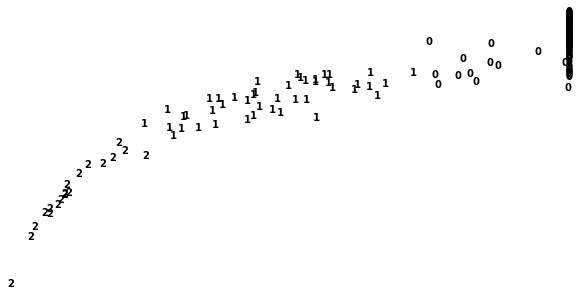

In [14]:
# Use k-means to cluster based on pyrimethamine sensitivity (adjusted_ic50 and auc)
k_means = KMeans(n_clusters=3, random_state=123)
y_pred = k_means.fit_predict(X_sens_mm)

plt.figure(figsize=(10, 5))

for i in range(X_sens_mm.shape[0]):
    plt.text(X_sens_mm['adjusted_ic50'][i], X_sens_mm['auc'][i], str(y_pred[i]),
             fontdict={'weight': 'bold', 'size': 10}
            )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [15]:
print(metrics.silhouette_score(X_sens_mm, y_pred, metric='euclidean'))

0.7670684080090362


Observations are not distributed isotropically, so k-means is probably not the best clustering model to use here.

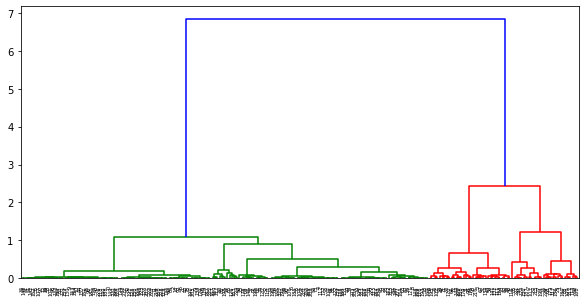

In [16]:
# Use dendrogram to select parameters for hierarchical clustering
plt.figure(figsize=(10, 5))
dendrogram(linkage(X_sens_mm, method='ward'))
plt.show()

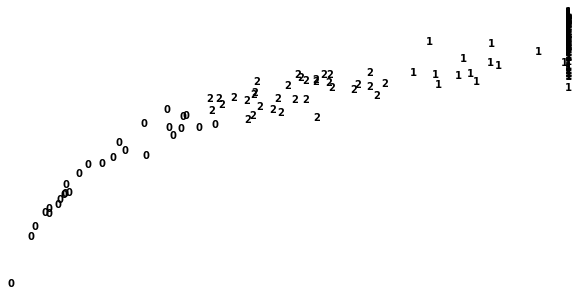

In [17]:
# Use hierarchical modeling to cluster based on pyrimethamine sensitivity (adjusted_ic50 and auc)
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=3)

y_pred = agg_cluster.fit_predict(X_sens_mm)

plt.figure(figsize=(10, 5))

for i in range(X_sens_mm.shape[0]):
    plt.text(X_sens_mm['adjusted_ic50'][i], X_sens_mm['auc'][i], str(y_pred[i]),
             fontdict={'weight': 'bold', 'size': 10}
            )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [18]:
print(metrics.silhouette_score(X_sens_mm, y_pred, metric='euclidean'))

0.7361761816040059


The agglomerative clustering model performed relatively well, but was slightly eclipsed in silhouette score by GMM (see below).

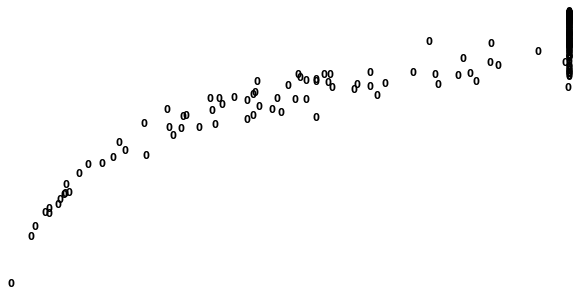

In [19]:
# Use DBSCAN to cluster based on pyrimethamine sensitivity (adjusted_ic50 and auc)
dbscan_cluster = DBSCAN(eps=5, min_samples=25)

y_pred = dbscan_cluster.fit_predict(X_sens_mm)

plt.figure(figsize=(10, 5))

for i in range(X_sens_mm.shape[0]):
    plt.text(X_sens_mm['adjusted_ic50'][i], X_sens_mm['auc'][i], str(y_pred[i]),
             fontdict={'weight': 'bold', 'size': 10}
            )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

I was unable to get more than one cluster using DBSCAN (tried eps ranging from 1-50 and min samples ranging from 5-150).

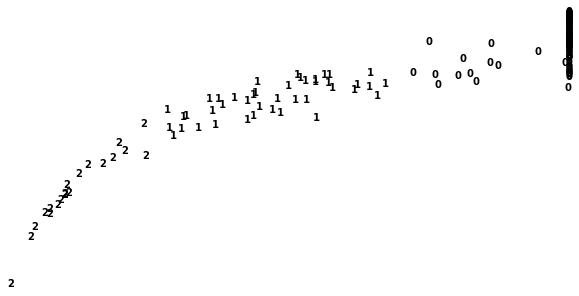

In [20]:
# Use gaussian mixture model (GMM) to cluster based on pyrimethamine sensitivity (adjusted_ic50 and auc)
gmm_cluster = GaussianMixture(n_components=3,
                              covariance_type='tied',
                              random_state=123)

y_pred = gmm_cluster.fit_predict(X_sens_mm)

plt.figure(figsize=(10, 5))

for i in range(X_sens_mm.shape[0]):
    plt.text(X_sens_mm['adjusted_ic50'][i], X_sens_mm['auc'][i], str(y_pred[i]),
             fontdict={'weight': 'bold', 'size': 10}
            )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [21]:
print(metrics.silhouette_score(X_sens_mm, y_pred, metric='euclidean'))

0.7634394637474717


GMM doesn't assume anything about the geometry of the clusters (unlike k-means), so it can be used to tackle non-linear and non-isotropic geometries. GMM resulted in the highest silhouette score outside of k-means, so I will use the GMM clustering results as my known outcome (y) moving forward where 0 refers to resistant, 1 refers to partially sensitive, and 2 refers to sensitive to pyrimethamine.

In [22]:
# Assign y_pred values to data frame and use 
# as outcome for following clustering analyses
y = pd.DataFrame(y_pred, columns=['pyr_sensitivity'], index=X_sens_mm.index)

# Check resulting data frame
y

pyr_sensitivity
0                  0
1                  1
2                  0
3                  1
4                  0
..               ...
226                0
227                0
228                0
229                1
230                0

[231 rows x 1 columns]

# Cluster Cell Lines Based on Gene Expression

## PCA for Dimensionality Reduction

In [23]:
# # Look at scree plot to determine optimal number of components
# Xt = X_exp_mm.T
# Cx = np.cov(Xt)

# eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# plt.plot(eig_val_cov)
# plt.show()

# print(eig_val_cov)

In [24]:
# The scree plot step above was too computationally intensive,
# so instead I decided to try different values for n_components 
# until I was able to capture >90% of the total variance

# Perform PCA rather than UMAP for dimensionality reduction
# based on computational considerations (PCA is faster than
# UMAP)
pca = PCA(n_components=146)
principal_components = pca.fit_transform(X_exp_mm)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA:\n',
    pca.explained_variance_ratio_,
    '\n\nThe cumulative percentage of total variance in the dataset explained by',
    'the components from Sklearn PCA:\n',
    pca.explained_variance_ratio_.cumsum()
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA:
 [0.13560103 0.09780121 0.04642399 0.03440917 0.03078502 0.0228922
 0.01972923 0.01720505 0.0150014  0.01359417 0.01303368 0.01224145
 0.01131945 0.01091571 0.0100343  0.0095879  0.00912746 0.00827891
 0.0078248  0.00757513 0.00740704 0.00697804 0.00677641 0.00639496
 0.00610519 0.00585743 0.00572964 0.00557068 0.00544762 0.00538965
 0.00528264 0.00514693 0.0050888  0.00493843 0.00478216 0.0046239
 0.00452887 0.0044415  0.00434434 0.00428881 0.00423943 0.00418368
 0.00413003 0.00399843 0.00396156 0.00389778 0.00385862 0.00385028
 0.00375359 0.00365261 0.0036285  0.00355183 0.00353203 0.00350965
 0.0034247  0.0034104  0.00333698 0.00329084 0.00328225 0.00323817
 0.00323173 0.00315267 0.00310489 0.00304914 0.00301238 0.00298611
 0.00296531 0.00290704 0.00286193 0.00282448 0.00282067 0.00279661
 0.00276093 0.00272991 0.00269466 0.00265856 0.00264565 0.0026065
 0.00259172 0.00256474 0.00252032 0.0

In [25]:
# Use pca components as features in model
X_pca = pd.DataFrame(data=principal_components)

# Review resulting data frame
X_pca

0          1          2          3         4         5    \
0   -13.454984  -3.321062   1.953295   1.296323 -7.691833  0.231600   
1    -7.914244  -6.833789  -4.333538  -3.373238  1.012240 -2.787449   
2   -14.763310  24.921885  17.190499  23.430926 -0.574997  6.935154   
3     4.194329   9.604906  -3.300882   4.348603 -1.684245 -0.380614   
4     6.541622  -1.973891  -4.499569   1.135018  1.296638 -2.510202   
..         ...        ...        ...        ...       ...       ...   
226  13.968188 -11.740035   6.701712   0.238215  0.812174  4.562096   
227  -7.993546 -10.247138  -2.461875  -3.783586  2.727650 -2.324235   
228  16.111586 -16.760484   5.246864   0.968185  0.723244  3.687701   
229  10.928890  -8.479959   2.955355   6.774872  1.257384  1.854985   
230   4.906568  10.967090   5.535759  -3.362256  1.138294  4.847356   

           6         7         8         9    ...       136       137  \
0     3.652678  4.547624  1.101510 -4.257934  ...  0.199216 -1.388596   
1     5.009444 -1.438243  1.910640  8.929369  ...  0.201820  2.462371   
2    16.920781 -0.705358 -4.530418 -1.485430  ... -0.223593 -0.471593   
3     1.437060 -0.076307 -1.507536 -0.965368  ... -0.512352 -1.199025   
4     0.760088 -1.500289  5.115201  1.041610  ... -0.179081  0.514185   
..         ...       ...       ...       ...  ...       ...       ...   
226  -0.914728  4.386488 -2.515959  0.551788  ... -1.570325 -0.090461   
227   8.580241 -4.347516  1.714516  5.527829  ... -0.918459 -1.054542   
228   1.263791  5.028719 -2.330488  1.086479  ... -0.342456 -0.173337   
229  -0.533001  0.856136  0.937964 -0.065969  ...  0.459197 -0.960952   
230   5.499272 -4.446226 -1.500607 -4.615905  ... -0.778874  0.031798   

          138       139       140       141       142       143       144  \
0    0.577617 -1.443356  0.564930 -0.030385 -0.004445 -1.277110 -1.199893   
1   -2.145031 -0.812470  1.197392  0.146424  1.422452  0.817925 -0.612713   
2   -0.122838 -0.258557  0.307383 -0.305887  0.234850  0.026172  0.640947   
3    0.105286  1.172814  0.015928 -0.414291 -0.867737 -1.663216  0.233255   
4    0.259709  0.304860 -0.276669  0.362861  0.233681  0.827812 -0.361709   
..        ...       ...       ...       ...       ...       ...       ...   
226  0.946978  0.206924 -0.513190  0.648957  1.619524  0.314876 -1.244904   
227  0.457725 -1.242467 -0.638439 -0.419549  0.404439 -0.003255  0.475960   
228 -0.716913  1.246468  0.813963 -1.682786 -1.441260 -0.424198  1.847628   
229 -0.442949 -1.053285 -0.645031  0.630115  0.825157 -2.252618 -0.654156   
230  0.038754  0.633726 -0.353435  1.566459  0.070051  0.159009  1.251634   

          145  
0    0.163047  
1    0.168684  
2    0.157282  
3   -1.481974  
4    0.240877  
..        ...  
226  0.096402  
227 -0.201370  
228 -1.737909  
229 -0.003383  
230  0.206702  

[231 rows x 146 columns]

In [26]:
# Use k-means to cluster based on gene expression (PCA)
k_means = KMeans(n_clusters=3, random_state=123)
y_pred = k_means.fit_predict(X_pca)

pca = PCA(n_components=2).fit_transform(X_pca)

plt.figure(figsize=(10, 5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color=colours[y['pyr_sensitivity'][i]],
             fontdict={'weight': 'bold', 'size': 200}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

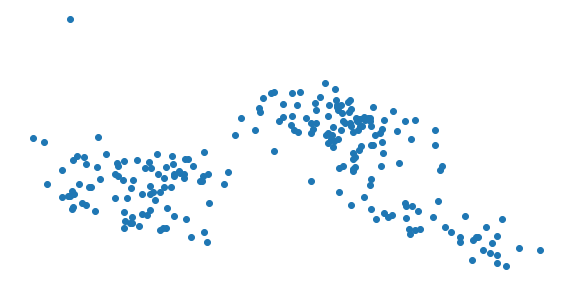

In [27]:
plt.figure(figsize=(10, 5))
plt.scatter(pca[:, 0], pca[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [28]:
# Evaluate adjusted rand index (ARI) and silhouette score
ari = metrics.adjusted_rand_score(y['pyr_sensitivity'], y_pred)
ss = metrics.silhouette_score(X_pca, y_pred, metric='euclidean')

print('ARI: {}\n'.format(ari))
print('Silhouette Score: {}'.format(ss))

ARI: -0.014748060702945607

Silhouette Score: 0.14621473689780087


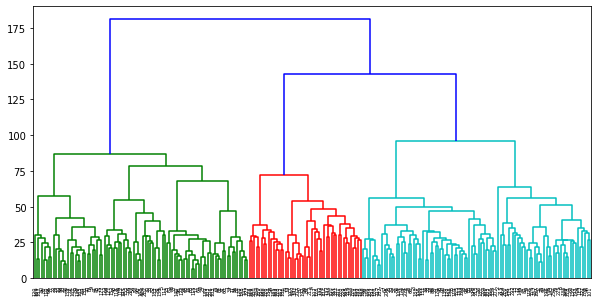

In [29]:
# Use dendrogram to select parameters for hierarchical clustering
plt.figure(figsize=(10, 5))
dendrogram(linkage(X_pca, method='ward'))
plt.show()

In [30]:
# Use hierarchical modeling to cluster based on gene expression (PCA)
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=3)

y_pred = agg_cluster.fit_predict(X_pca)

pca = PCA(n_components=2).fit_transform(X_pca)

plt.figure(figsize=(10, 5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color=colours[y['pyr_sensitivity'][i]],
             fontdict={'weight': 'bold', 'size': 200}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

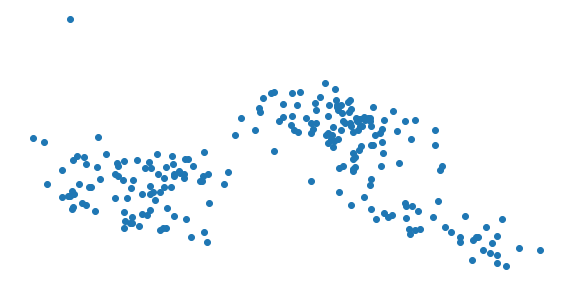

In [31]:
plt.figure(figsize=(10, 5))
plt.scatter(pca[:, 0], pca[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [32]:
# Evaluate adjusted rand index (ARI) and silhouette score
ari = metrics.adjusted_rand_score(y['pyr_sensitivity'], y_pred)
ss = metrics.silhouette_score(X_pca, y_pred, metric='euclidean')

print('ARI: {}\n'.format(ari))
print('Silhouette Score: {}'.format(ss))

ARI: -0.012091865609753654

Silhouette Score: 0.14342890494286165


In [33]:
# Use DBSCAN to cluster based on gene expression (PCA)
dbscan_cluster = DBSCAN(eps=24, min_samples=8)

y_pred = dbscan_cluster.fit_predict(X_pca)

pca = PCA(n_components=2).fit_transform(X_pca)

plt.figure(figsize=(10, 5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color=colours[y['pyr_sensitivity'][i]],
             fontdict={'weight': 'bold', 'size': 200}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

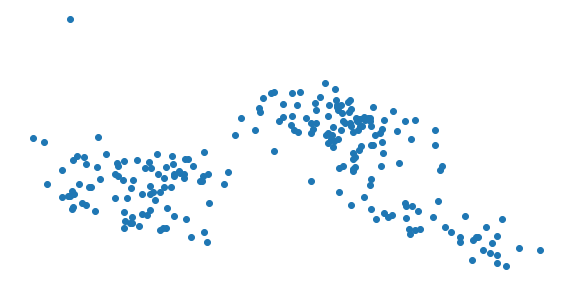

In [34]:
plt.figure(figsize=(10, 5))
plt.scatter(pca[:, 0], pca[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [35]:
# Evaluate adjusted rand index (ARI) and silhouette score
ari = metrics.adjusted_rand_score(y['pyr_sensitivity'], y_pred)
ss = metrics.silhouette_score(X_pca, y_pred, metric='euclidean')

print('ARI: {}\n'.format(ari))
print('Silhouette Score: {}'.format(ss))

ARI: -0.015876875659105213

Silhouette Score: 0.09443366703773569


In [36]:
# Use GMM to cluster based on gene expression (PCA)
gmm_cluster = GaussianMixture(n_components=3,
                              covariance_type='tied',
                              random_state=123)

y_pred = gmm_cluster.fit_predict(X_pca)

pca = PCA(n_components=2).fit_transform(X_pca)

plt.figure(figsize=(10, 5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color=colours[y['pyr_sensitivity'][i]],
             fontdict={'weight': 'bold', 'size': 200}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

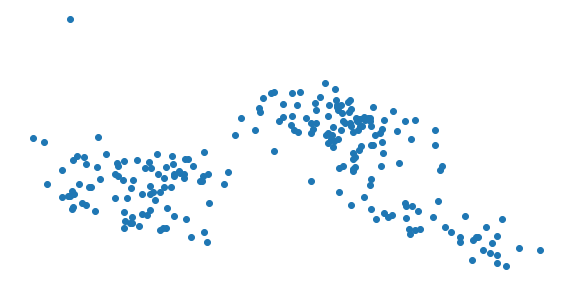

In [37]:
plt.figure(figsize=(10, 5))
plt.scatter(pca[:, 0], pca[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [38]:
# Evaluate adjusted rand index (ARI) and silhouette score
ari = metrics.adjusted_rand_score(y['pyr_sensitivity'], y_pred)
ss = metrics.silhouette_score(X_pca, y_pred, metric='euclidean')

print('ARI: {}\n'.format(ari))
print('Silhouette Score: {}'.format(ss))

ARI: -0.014748060702945607

Silhouette Score: 0.14621473689780087


## UMAP for Dimensionality Reduction

### What is the best way to pick n_components for UMAP?

In [39]:
results = umap.UMAP(n_components=100).fit_transform(X_exp_mm)
results.shape

(231, 100)

In [40]:
# Use umap components as features in model
X_umap = pd.DataFrame(data=results)

# Review resulting data frame
X_umap

0         1         2         3         4         5         6   \
0   -7.060588  0.414141 -1.349990 -0.000677  0.466158  0.555334 -1.748623   
1   -6.831770  0.061258 -1.713107 -0.328945  0.351951  0.655230 -2.238638   
2    4.460014 -1.918447 -0.208217 -1.022634 -0.330750 -0.138492 -0.774050   
3    4.623637 -1.413706 -0.232618 -0.415079 -0.419363 -0.016840 -0.275423   
4    4.594845 -1.370455 -0.305667 -0.277603 -0.355431 -0.014721 -0.268000   
..        ...       ...       ...       ...       ...       ...       ...   
226  4.903982 -0.082453 -1.036985  0.628422  0.656203 -0.109930  0.711896   
227 -6.858234  0.060725 -1.818641 -0.399103  0.273906  0.684401 -2.275971   
228  4.928738 -0.059098 -1.059069  0.619274  0.827737 -0.119912  0.739628   
229  4.954211 -0.235506 -0.992735  0.526863  0.430892 -0.319404  0.553504   
230  4.833570 -1.827029 -0.106651 -0.978161 -0.417839 -0.158559 -0.766649   

           7         8         9   ...        90        91        92  \
0    0.303798  0.212182 -1.225703  ...  0.232841  0.716388  0.479689   
1   -0.163489  0.033646 -1.218347  ...  0.276746  0.949553  0.409914   
2    0.732622 -0.623114  0.495988  ... -0.790536  0.531992 -0.651865   
3    0.422233 -0.343601  0.898699  ... -0.493390  0.321117 -0.640170   
4    0.385165 -0.151150  0.898526  ... -0.443853  0.327271 -0.671638   
..        ...       ...       ...  ...       ...       ...       ...   
226  0.502413  0.899048  1.155557  ...  0.362412  0.164210 -0.410194   
227 -0.200959  0.002930 -1.253308  ...  0.281128  0.955195  0.357990   
228  0.534135  1.013041  1.148535  ...  0.387085  0.161797 -0.389817   
229  0.309977  0.687867  1.160930  ...  0.212789  0.216715 -0.437409   
230  0.716603 -0.662308  0.602891  ... -0.815418  0.472879 -0.707272   

           93        94        95        96        97        98        99  
0   -0.163832  0.743783  0.090105 -0.188571 -0.067779  0.879431  0.003663  
1   -0.449062  0.741443 -0.037780 -0.139732  0.064093  0.692811 -0.171293  
2    0.533915 -0.786129  0.234725 -0.020811 -0.273807 -0.393872  0.231677  
3    0.556108 -0.716531  0.260227 -0.120620 -0.194032 -0.410154  0.249717  
4    0.503360 -0.692271  0.274311 -0.047319 -0.127254 -0.404746  0.330910  
..        ...       ...       ...       ...       ...       ...       ...  
226  0.473239 -0.625197  0.208969  0.181803  0.041719 -0.444399  0.560239  
227 -0.462268  0.720951 -0.026927 -0.142075  0.085502  0.605969 -0.164428  
228  0.472209 -0.615001  0.199000  0.174278  0.050786 -0.447144  0.555740  
229  0.401222 -0.634113  0.193603  0.125691  0.079181 -0.477820  0.502328  
230  0.475863 -0.847561  0.189694  0.017927 -0.205025 -0.360429  0.258733  

[231 rows x 100 columns]

In [44]:
# Use k-means to cluster based on gene expression (UMAP)
k_means = KMeans(n_clusters=6, random_state=123)
y_pred = k_means.fit_predict(X_umap)

umap_results = umap.UMAP(n_neighbors=25,
                      min_dist=0.9,
                      metric='correlation').fit_transform(X_umap)

plt.figure(figsize=(10, 5))
colours = 'rbg'
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], str(y_pred[i]),
             color=colours[y['pyr_sensitivity'][i]],
             fontdict={'weight': 'bold', 'size': 200}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


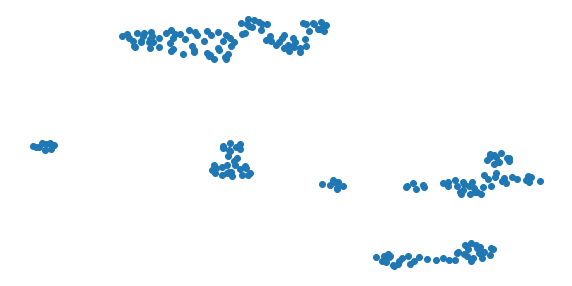

In [45]:
plt.figure(figsize=(10, 5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [46]:
# Evaluate adjusted rand index (ARI) and silhouette score
ari = metrics.adjusted_rand_score(y['pyr_sensitivity'], y_pred)
ss = metrics.silhouette_score(X_umap, y_pred, metric='euclidean')

print('ARI: {}\n'.format(ari))
print('Silhouette Score: {}'.format(ss))

ARI: 0.009781200728017931

Silhouette Score: 0.6035844683647156
